# Pytorch画像認識のチュートリアル

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

### 画像データの取得

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#torchvisionに標準で入っているデータセットを利用
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 学習データはシャッフルする
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


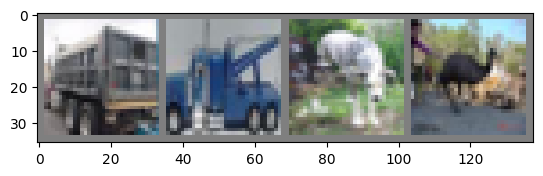

truck truck   dog  bird


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 画像の表示関数


def imshow(img):
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 適当な訓練セットの画像を取得
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 各層の準備

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 60)
        self.fc3 = nn.Linear(60, 10)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.3)
    #ニューラルネットの形を決める
    def forward(self, x):
        x = self.bn1(self.pool(F.elu(self.conv1(x)))) #畳み込んでreluに入れる(負の数を0にする), その後プーリング　(32-4)/2*(32-4)/2 → 14*14
        x = self.bn2(self.pool(F.elu(self.conv2(x)))) #畳み込んでreluに入れる(負の数を0にする) (14-4)/2*(14-4)/2 → 5*5
        x = x.view(-1, 16 * 5 * 5) # 一次元平坦化
        x = F.elu(self.fc1(x))    # 全結合
        x = F.elu(self.fc2(x))    # 全結合
        x = self.dropout(x)
        x = self.fc3(x)           # 最終層
        return x

net = Net()

### self.conv1 = nn.Conv2d(3, 6, 5)の意味

#### 入力チャネル数: 3


入力画像のチャネル数を表します
この場合、RGBカラー画像を入力とすることを示しています

Red (赤)チャネル
Green (緑)チャネル
Blue (青)チャネル


グレースケール画像の場合は1になります


#### 出力チャネル数: 6


出力される特徴マップの数を表します
つまり、6個の異なるフィルタを学習することを意味します
各フィルタが異なる特徴（エッジ、テクスチャなど）を検出します


#### カーネルサイズ: 5


フィルタの大きさを表します
この場合、5x5のサイズのフィルタを使用します
よく使われるサイズ：3x3, 5x5, 7x7など

大きいサイズ：より広い範囲の特徴を捉えられる
小さいサイズ：局所的な特徴を捉えられる

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(7):  # エポック数分ループを回します

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      # データセットのデータを [inputs, labels]の形で取得
      inputs, labels = data

      # パラメータの勾配をリセット
      optimizer.zero_grad()

      # 順伝搬＋逆伝搬＋パラメータ更新
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # 統計情報の表示
      running_loss += loss.item()
      if i % 2000 == 1999:    # 2,000ミニバッチにつき1度表示
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
          running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.866
[1,  4000] loss: 1.668
[1,  6000] loss: 1.574
[1,  8000] loss: 1.517
[1, 10000] loss: 1.476
[1, 12000] loss: 1.411
[2,  2000] loss: 1.363
[2,  4000] loss: 1.351
[2,  6000] loss: 1.345
[2,  8000] loss: 1.315
[2, 10000] loss: 1.317
[2, 12000] loss: 1.296
[3,  2000] loss: 1.213
[3,  4000] loss: 1.212
[3,  6000] loss: 1.232
[3,  8000] loss: 1.210
[3, 10000] loss: 1.208
[3, 12000] loss: 1.206
[4,  2000] loss: 1.137
[4,  4000] loss: 1.157
[4,  6000] loss: 1.132
[4,  8000] loss: 1.139
[4, 10000] loss: 1.123
[4, 12000] loss: 1.131
[5,  2000] loss: 1.064
[5,  4000] loss: 1.057
[5,  6000] loss: 1.081
[5,  8000] loss: 1.054
[5, 10000] loss: 1.077
[5, 12000] loss: 1.089


In [1]:
PATH = 'models/cifar_net7.pth'
torch.save(net.state_dict(), PATH)

NameError: name 'torch' is not defined

### ONNX形式でのエクスポート

In [12]:
# エクスポート先のパスを設定
ONNX_PATH = './cifar_net3.onnx'

# ダミー入力の作成
# CIFARの場合、入力サイズは(バッチサイズ, チャンネル数, 高さ, 幅)
dummy_input = torch.randn(1, 3, 32, 32)

# ONNXフォーマットでエクスポート
torch.onnx.export(
    net,                    # モデル
    dummy_input,           # モデルの入力として使用するダミーデータ
    ONNX_PATH,            # 出力ファイルパス
    export_params=True,    # モデルファイルにトレーニング済みのパラメータを含める
    opset_version=11,      # ONNXのバージョン
    do_constant_folding=True,  # 定数折りたたみを最適化する
    input_names=['input'],     # 入力の名前
    output_names=['output'],   # 出力の名前
    dynamic_axes={
        'input': {0: 'batch_size'},  # 可変のバッチサイズ
        'output': {0: 'batch_size'}
    }
)

OnnxExporterError: Module onnx is not installed!

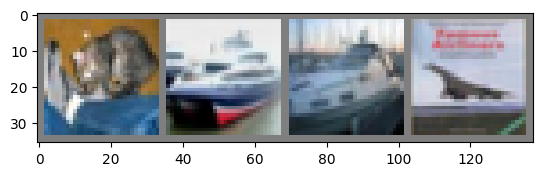

GroundTruth:    cat  ship  ship plane


In [51]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 画像と正解ラベルの表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [59]:
outputs = net(images)

In [60]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog   dog   cat horse


In [61]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [62]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 78 %
Accuracy of  bird : 51 %
Accuracy of   cat : 40 %
Accuracy of  deer : 61 %
Accuracy of   dog : 44 %
Accuracy of  frog : 68 %
Accuracy of horse : 66 %
Accuracy of  ship : 71 %
Accuracy of truck : 66 %
